# Hovmoller plots

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import geopandas
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from netCDF4 import Dataset
import os
import glob
import plotly.express as px

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

# Make functions to plot

In [3]:
# function to read data path
def path_to_ds(variable,year):
    indir = '/g/data/rt52/era5/single-levels/reanalysis/'+variable+'/'+year+'/' # path to where data is saved
    print('indir: ',indir)
    file = indir+variable+'_era5_oper_sfc_20220201-20220228.nc' # path to file
    print('file: ',file)
    return file

# Using the function: variable names are 10u and 2t
era5_ds = xr.open_dataset(path_to_ds("10u","2022"), engine="netcdf4")

indir:  /g/data/rt52/era5/single-levels/reanalysis/10u/2022/
file:  /g/data/rt52/era5/single-levels/reanalysis/10u/2022/10u_era5_oper_sfc_20220201-20220228.nc


In [14]:
# define function to plot
def plot_hovmoller(variable,suptitle,level_data,cmap,cbar_units,anomaly=None):
    start_time = '2022-02-08T00:00:00'
    end_time = '2022-02-15T23:00:00'
    time_slice = slice(start_time, end_time)
    lat_slice_T = -19.5
    lat_slice_C = -16.75
    lat_slice_W = -16.25
    lon_slice_T = slice(144, 149)                  
    lon_slice_C = slice(143,148)
    lon_slice_W = slice(147,153)

    # Get data, selecting time, lat/lon slice
    if anomaly==True:
        variable_data_T = era5_ds[variable].sel(latitude=lat_slice_T,longitude=lon_slice_T,
                        time=time_slice).groupby("time.day") - era5_ds[variable].sel(latitude=lat_slice_T,longitude=lon_slice_T,
                        time=time_slice).groupby("time.day").mean()

        variable_data_C = era5_ds[variable].sel(latitude=lat_slice_C,longitude=lon_slice_C,
                        time=time_slice).groupby("time.day") - era5_ds[variable].sel(latitude=lat_slice_C,longitude=lon_slice_C,
                        time=time_slice).groupby("time.day").mean()

        variable_data_W = era5_ds[variable].sel(latitude=lat_slice_W,longitude=lon_slice_W,
                        time=time_slice).groupby("time.day") - era5_ds[variable].sel(latitude=lat_slice_W,longitude=lon_slice_W,
                        time=time_slice).groupby("time.day").mean()
        
    else:
        variable_data_T = era5_ds[variable].sel(latitude=lat_slice_T,longitude=lon_slice_T,time=time_slice)
        variable_data_C = era5_ds[variable].sel(latitude=lat_slice_C,longitude=lon_slice_C,time=time_slice)
        variable_data_W = era5_ds[variable].sel(latitude=lat_slice_W,longitude=lon_slice_W,time=time_slice)

    # Get times and make array of datetime objects
    variable_times_T = variable_data_T.time.values.astype('datetime64[ms]').astype('O')
    variable_times_C = variable_data_C.time.values.astype('datetime64[ms]').astype('O')
    variable_times_W = variable_data_W.time.values.astype('datetime64[ms]').astype('O')

    # Specify longitude values for chosen domain
    lons_T = variable_data_T.longitude.values
    lons_C = variable_data_C.longitude.values
    lons_W = variable_data_W.longitude.values 
    
    # make plot
    fig, ax = plt.subplots(1,3,figsize=(18,10))
    fig.patch.set_facecolor('white')

    # Set some titles
    ax[0].set_title('Townsville, lat=-19.5', loc='left', fontsize=20,fontweight=0.9)
    ax[1].set_title('Cairns, lat=-16.75', loc='left', fontsize=20,fontweight=0.9)
    ax[2].set_title('Willis Island, lat=-16.25', loc='left', fontsize=20,fontweight=0.9)
    fig.figure.suptitle(suptitle,fontsize=30) #,x=0.2,y=0.98,

    # Plot of chosen variable averaged over latitude and slightly smoothed
    levels = level_data
    cf_T = ax[0].contourf(lons_T, variable_times_T, variable_data_T, levels=levels, cmap=cmap, extend='both')
    cf_C = ax[1].contourf(lons_C, variable_times_C, variable_data_C, levels=levels, cmap=cmap, extend='both')
    cf_W = ax[2].contourf(lons_W, variable_times_W, variable_data_W, levels=levels, cmap=cmap, extend='both')

    line_colors = ['black' for l in cf_T.levels]
    cs_T = ax[0].contour(lons_T, variable_times_T, variable_data_T, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
    cs_C = ax[1].contour(lons_C, variable_times_C, variable_data_C, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
    cs_W = ax[2].contour(lons_W, variable_times_W, variable_data_W, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')                 
                    
    # cbar and cbar label                
    cbar_W = plt.colorbar(cf_W, ax=ax[2],orientation='vertical', pad=0.04, aspect=30, extendrect=True)
    cbar_W.set_label(cbar_units,fontsize=15)
    
    # plot vertical lines to represent coastlines
    ax[0].axvline(147.5,color='blue',alpha=0.2,linestyle='--')
    ax[1].axvline(145.75,color='blue',alpha=0.2,linestyle='--')
    
    # plot locations of radars
    ax[0].axvline(146.5509,color='k',alpha=0.5,linestyle='-.')
    ax[1].axvline(145.683,color='k',alpha=0.5,linestyle='-.')
    ax[2].axvline(149.9646,color='k',alpha=0.5,linestyle='-.')
    
    # Make some ticks and tick labels
    xticks_T = np.arange(144,150,1)
    xticks_C = np.arange(143,149,1)
    xticks_W = np.arange(147,154,1)            
    ax[0].set_xticks(xticks_T)
    ax[1].set_xticks(xticks_C)
    ax[2].set_xticks(xticks_W)
                    
    x_tick_labels_T = ["144","145","146","147","148","149"]
    x_tick_labels_C = ["143","144","145","146","147","148"]
    x_tick_labels_W = ["147","148","149","150","151","152","153"]        
    ax[0].set_xticklabels(x_tick_labels_T)
    ax[1].set_xticklabels(x_tick_labels_C)
    ax[2].set_xticklabels(x_tick_labels_W)

    ax[1].set(yticklabels=[]) 
    ax[2].set(yticklabels=[]) 
                    
    ax[0].set_xlabel("Longitude",fontsize=15)
    ax[1].set_xlabel("Longitude",fontsize=15)
    ax[2].set_xlabel("Longitude",fontsize=15)
    ax[0].set_ylabel("Day",fontsize=20)            
                    
    fig.tight_layout()
    plt.show()
    return

indir:  /g/data/rt52/era5/single-levels/reanalysis/10u/2022/
file:  /g/data/rt52/era5/single-levels/reanalysis/10u/2022/10u_era5_oper_sfc_20220201-20220228.nc


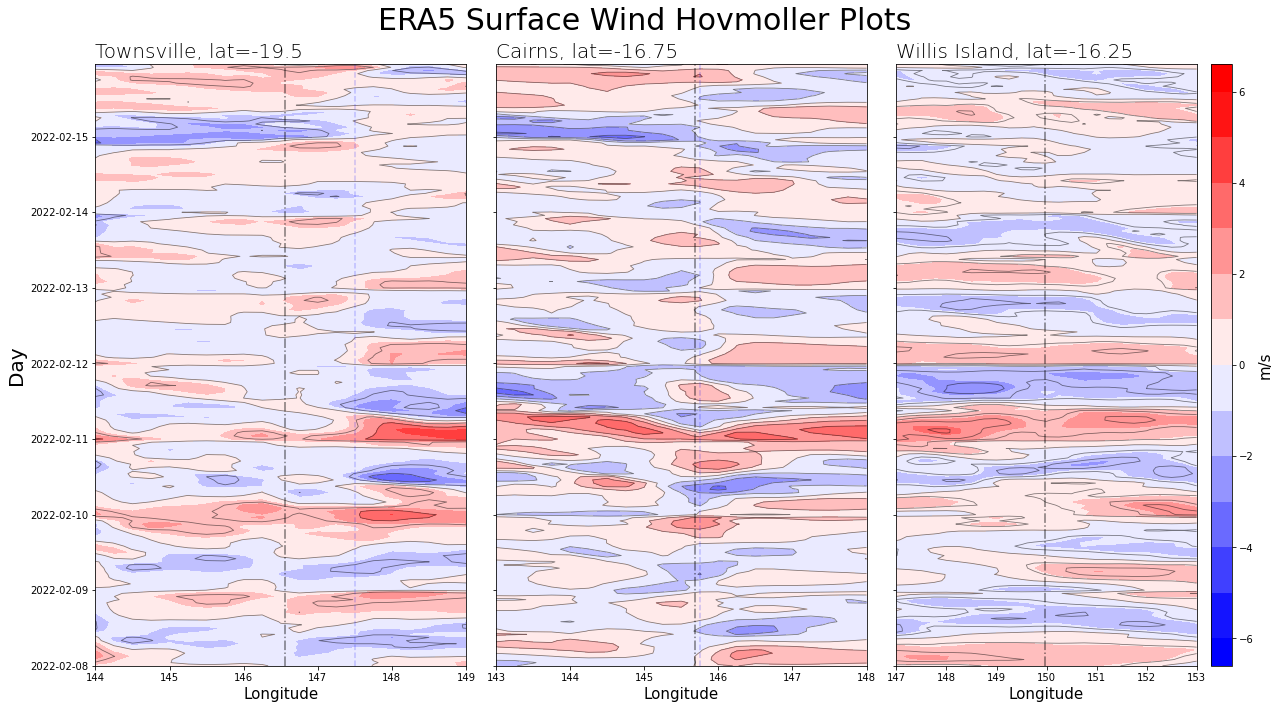

In [15]:
era5_ds = xr.open_dataset(path_to_ds("10u","2022"), engine="netcdf4")
plot_hovmoller("u10","ERA5 Surface Wind Hovmoller Plots",[-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6],"bwr","m/s",anomaly=True)

indir:  /g/data/rt52/era5/single-levels/reanalysis/2t/2022/
file:  /g/data/rt52/era5/single-levels/reanalysis/2t/2022/2t_era5_oper_sfc_20220201-20220228.nc


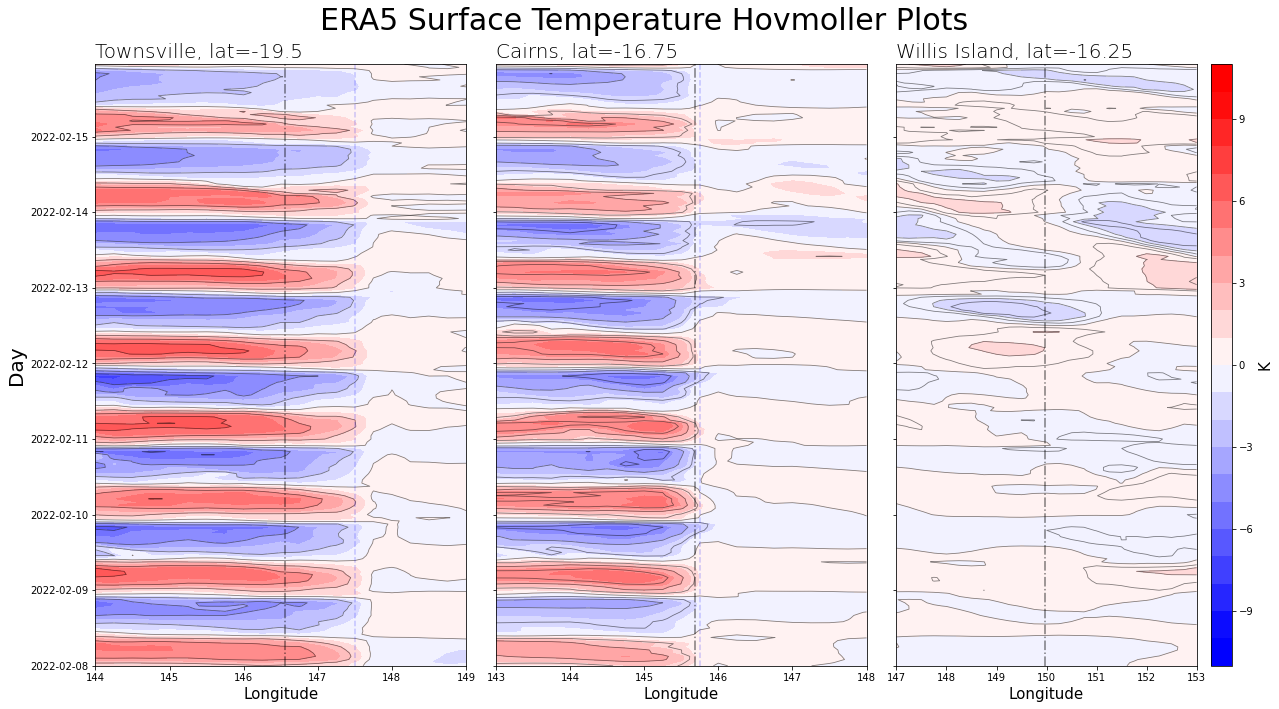

In [16]:
era5_ds = xr.open_dataset(path_to_ds("2t","2022"), engine="netcdf4")
plot_hovmoller("t2m","ERA5 Surface Temperature Hovmoller Plots",[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10],"bwr","K",anomaly=True)

# 10m U Wind Component plots

In [16]:
# read in era5 data
variable = '10u'
Year = '2022'
indir = '/g/data/rt52/era5/single-levels/reanalysis/'+variable+'/'+Year+'/' # path to where data is saved
print('indir: ',indir)
file = indir+variable+'_era5_oper_sfc_20220201-20220228.nc' # path to file
print('file: ',file)
nc = Dataset(file, mode='r')                      # read the data 
print(type(nc))                                   # print the type of the data 
print(nc.variables.keys())                        # print variable keys

indir:  /g/data/rt52/era5/single-levels/reanalysis/10u/2022/
file:  /g/data/rt52/era5/single-levels/reanalysis/10u/2022/10u_era5_oper_sfc_20220201-20220228.nc
<class 'netCDF4._netCDF4.Dataset'>
dict_keys(['longitude', 'latitude', 'time', 'u10'])


In [166]:
era5_ds = xr.open_dataset(file, engine="netcdf4")
era5_ds["u10"].units

'm s**-1'

In [167]:
# Prepare data + make plots: https://unidata.github.io/python-gallery/examples/Hovmoller_Diagram.html
# create time slices between 25th and 28th
start_time = '2022-02-08T00:00:00'
end_time = '2022-02-15T23:00:00'
time_slice = slice(start_time, end_time)
lat_slice = -19  #-16 degrees is cairns latitude, -19 degrees is Townsville
lat_slice_C = -17
lat_slice_W = -16.25
lon_slice = slice(144, 149)                  # 143-148 is longitude for zoomed in version of Townsville and Cairns
lon_slice_C = slice(143,148)
lon_slice_W = slice(147,153)

# Get data, selecting time, lat/lon slice
variable_data = era5_ds["u10"].sel(latitude=lat_slice,longitude=lon_slice,time=time_slice)
variable_data_C = era5_ds["u10"].sel(latitude=lat_slice_C,longitude=lon_slice_C,time=time_slice)
variable_data_W = era5_ds["u10"].sel(latitude=lat_slice_W,longitude=lon_slice_W,time=time_slice)

# Get times and make array of datetime objects
variable_times = variable_data.time.values.astype('datetime64[ms]').astype('O')
variable_times_C = variable_data_C.time.values.astype('datetime64[ms]').astype('O')
variable_times_W = variable_data_W.time.values.astype('datetime64[ms]').astype('O')

# Specify longitude values for chosen domain
lons = variable_data.longitude.values
lons_C = variable_data_C.longitude.values
lons_W = variable_data_W.longitude.values                   

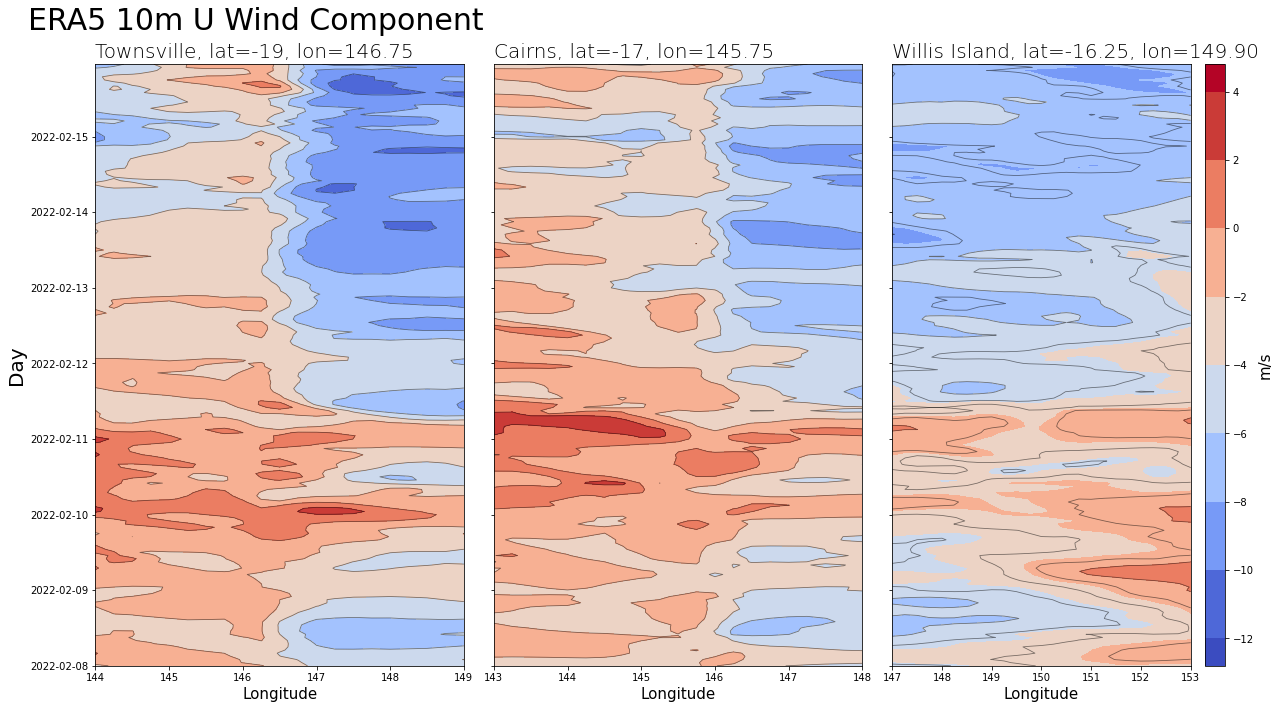

In [168]:
# make plot
fig, ax = plt.subplots(1,3,figsize=(18,10))
fig.patch.set_facecolor('white')

# Set some titles
ax[0].set_title('Townsville, lat=-19, lon=146.75', loc='left', fontsize=20,fontweight=0.9)
ax[1].set_title('Cairns, lat=-17, lon=145.75', loc='left', fontsize=20,fontweight=0.9)
ax[2].set_title('Willis Island, lat=-16.25, lon=149.90', loc='left', fontsize=20,fontweight=0.9)
fig.figure.suptitle("ERA5 10m U Wind Component",x=0.2,y=0.98,fontsize=30)

# Plot of chosen variable averaged over latitude and slightly smoothed
levels = [-12, -10 , -8, -6, -4 , -2 , 0, 2, 4]
cf = ax[0].contourf(lons, variable_times, variable_data, levels=levels, cmap="coolwarm", extend='both')
cf_C = ax[1].contourf(lons_C, variable_times_C, variable_data_C, levels=levels, cmap="coolwarm", extend='both')
cf_W = ax[2].contourf(lons_W, variable_times_W, variable_data_W, levels=levels, cmap="coolwarm", extend='both')

line_colors = ['black' for l in cf.levels]
cs = ax[0].contour(lons, variable_times, variable_data, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
cs_C = ax[1].contour(lons_C, variable_times_C, variable_data_C, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
cs_W = ax[2].contour(lons_W, variable_times_W, variable_data_W, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')                 
                    
# cbar and cbar label                
cbar_W = plt.colorbar(cf_W, ax=ax[2],orientation='vertical', pad=0.04, aspect=30, extendrect=True)
cbar_W.set_label('m/s',fontsize=15)

# Make some ticks and tick labels
xticks = np.arange(144,150,1)
xticks_C = np.arange(143,149,1)
xticks_W = np.arange(147,154,1)            
ax[0].set_xticks(xticks)
ax[1].set_xticks(xticks_C)
ax[2].set_xticks(xticks_W)
                    
x_tick_labels = ["144","145","146","147","148","149"]
x_tick_labels_C = ["143","144","145","146","147","148"]
x_tick_labels_W = ["147","148","149","150","151","152","153"]        
ax[0].set_xticklabels(x_tick_labels)
ax[1].set_xticklabels(x_tick_labels_C)
ax[2].set_xticklabels(x_tick_labels_W)

ax[1].set(yticklabels=[]) 
ax[2].set(yticklabels=[]) 
                    
ax[0].set_xlabel("Longitude",fontsize=15)
ax[1].set_xlabel("Longitude",fontsize=15)
ax[2].set_xlabel("Longitude",fontsize=15)
ax[0].set_ylabel("Day",fontsize=20)            
                    
#figs = ax[0].get_figure()
#figs.savefig(outdir+"Hovmoller_2022_02_u10")
fig.tight_layout()
plt.show()

# 10m U Wind Anomaly plots

In [3]:
# read in era5 data
variable = '10u'
Year = '2022'
indir = '/g/data/rt52/era5/single-levels/reanalysis/'+variable+'/'+Year+'/' # path to where data is saved
print('indir: ',indir)
file = indir+variable+'_era5_oper_sfc_20220201-20220228.nc' # path to file
print('file: ',file)
nc = Dataset(file, mode='r')                      # read the data 
print(type(nc))                                   # print the type of the data 
print(nc.variables.keys())

indir:  /g/data/rt52/era5/single-levels/reanalysis/10u/2022/
file:  /g/data/rt52/era5/single-levels/reanalysis/10u/2022/10u_era5_oper_sfc_20220201-20220228.nc
<class 'netCDF4._netCDF4.Dataset'>
dict_keys(['longitude', 'latitude', 'time', 'u10'])


In [4]:
era5_ds = xr.open_dataset(file, engine="netcdf4")
era5_ds["u10"].units

'm s**-1'

In [7]:
# Prepare data + make plots: https://unidata.github.io/python-gallery/examples/Hovmoller_Diagram.html
# create time slices between 25th and 28th
start_time = '2022-02-08T00:00:00'
end_time = '2022-02-15T23:00:00'
time_slice = slice(start_time, end_time)
lat_slice = -19  #-16 degrees is cairns latitude, -19 degrees is Townsville
lat_slice_C = -17
lat_slice_W = -16.25
lon_slice = slice(144, 149)                  # 143-148 is longitude for zoomed in version of Townsville and Cairns
lon_slice_C = slice(143,148)
lon_slice_W = slice(147,153)

# for daily anomaly: 
#anom = era5_ds["u10"].sel(latitude=lat_slice,longitude=lon_slice).groupby("time.day") - 
#        era5_ds["u10"].sel(latitude=lat_slice,longitude=lon_slice).groupby("time.day").mean("time")


# Get data, selecting time, lat/lon slice
variable_data = era5_ds["u10"].sel(latitude=lat_slice,longitude=lon_slice,
                        time=time_slice).groupby("time.day") - era5_ds["u10"].sel(latitude=lat_slice,longitude=lon_slice,
                        time=time_slice).groupby("time.day").mean()

variable_data_C = era5_ds["u10"].sel(latitude=lat_slice_C,longitude=lon_slice_C,
                        time=time_slice).groupby("time.day") - era5_ds["u10"].sel(latitude=lat_slice_C,longitude=lon_slice_C,
                        time=time_slice).groupby("time.day").mean()

variable_data_W = era5_ds["u10"].sel(latitude=lat_slice_W,longitude=lon_slice_W,
                        time=time_slice).groupby("time.day") - era5_ds["u10"].sel(latitude=lat_slice_W,longitude=lon_slice_W,
                        time=time_slice).groupby("time.day").mean()

# Get times and make array of datetime objects
variable_times = variable_data.time.values.astype('datetime64[ms]').astype('O')
variable_times_C = variable_data_C.time.values.astype('datetime64[ms]').astype('O')
variable_times_W = variable_data_W.time.values.astype('datetime64[ms]').astype('O')

# Specify longitude values for chosen domain
lons = variable_data.longitude.values
lons_C = variable_data_C.longitude.values
lons_W = variable_data_W.longitude.values 

In [9]:
era5_ds["u10"].sel(latitude=-19)

<xarray.DataArray 'u10' (time: 672, longitude: 1440)>
[967680 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    latitude   float32 -19.0
  * time       (time) datetime64[ns] 2022-02-01 ... 2022-02-28T23:00:00
Attributes:
    units:      m s**-1
    long_name:  10 metre U wind component

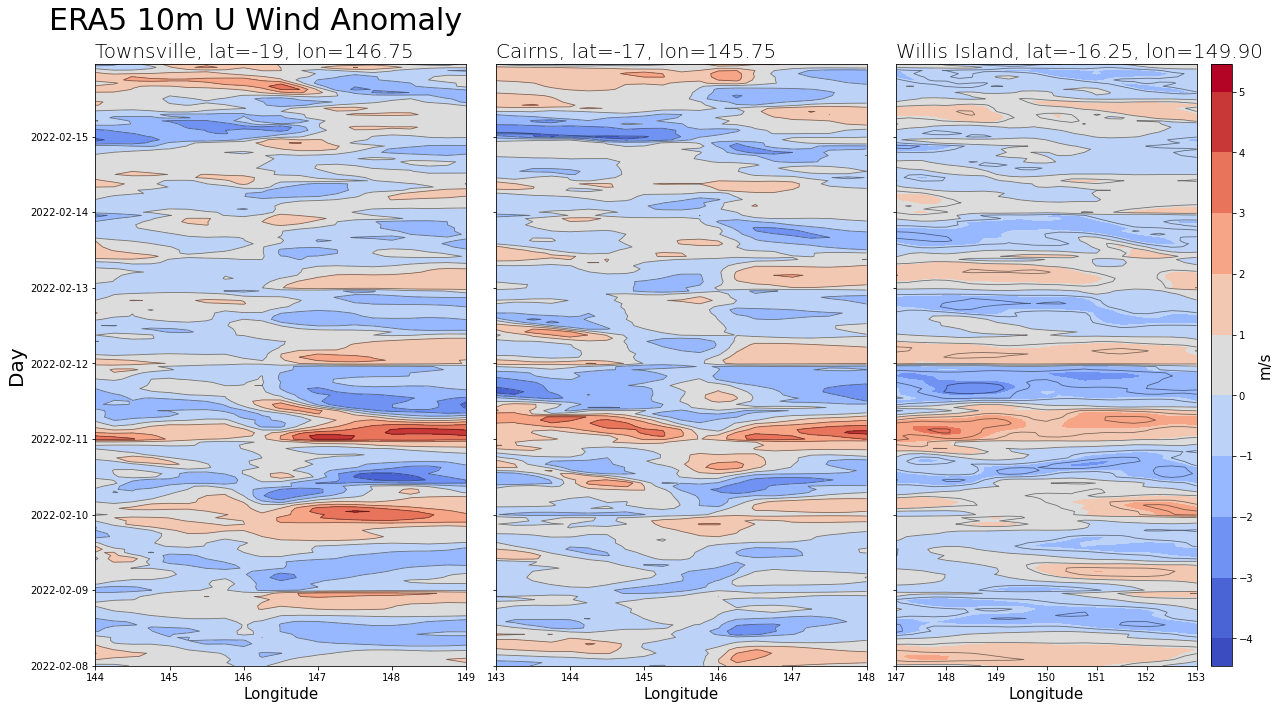

In [20]:
# make plot
fig, ax = plt.subplots(1,3,figsize=(18,10))
fig.patch.set_facecolor('white')

# Set some titles
ax[0].set_title('Townsville, lat=-19, lon=146.75', loc='left', fontsize=20,fontweight=0.9)
ax[1].set_title('Cairns, lat=-17, lon=145.75', loc='left', fontsize=20,fontweight=0.9)
ax[2].set_title('Willis Island, lat=-16.25, lon=149.90', loc='left', fontsize=20,fontweight=0.9)
fig.figure.suptitle("ERA5 10m U Wind Anomaly",x=0.2,y=0.98,fontsize=30)

# Plot of chosen variable averaged over latitude and slightly smoothed
levels = [-4,-3,-2,-1,0,1,2,3,4,5]
cf = ax[0].contourf(lons, variable_times, variable_data, levels=levels, cmap="coolwarm", extend='both')
cf_C = ax[1].contourf(lons_C, variable_times_C, variable_data_C, levels=levels, cmap="coolwarm", extend='both')
cf_W = ax[2].contourf(lons_W, variable_times_W, variable_data_W, levels=levels, cmap="coolwarm", extend='both')

line_colors = ['black' for l in cf.levels]
cs = ax[0].contour(lons, variable_times, variable_data, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
cs_C = ax[1].contour(lons_C, variable_times_C, variable_data_C, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
cs_W = ax[2].contour(lons_W, variable_times_W, variable_data_W, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')                 
                    
# cbar and cbar label                
cbar_W = plt.colorbar(cf_W, ax=ax[2],orientation='vertical', pad=0.04, aspect=30, extendrect=True)
cbar_W.set_label('m/s',fontsize=15)

# Make some ticks and tick labels
xticks = np.arange(144,150,1)
xticks_C = np.arange(143,149,1)
xticks_W = np.arange(147,154,1)            
ax[0].set_xticks(xticks)
ax[1].set_xticks(xticks_C)
ax[2].set_xticks(xticks_W)
                    
x_tick_labels = ["144","145","146","147","148","149"]
x_tick_labels_C = ["143","144","145","146","147","148"]
x_tick_labels_W = ["147","148","149","150","151","152","153"]        
ax[0].set_xticklabels(x_tick_labels)
ax[1].set_xticklabels(x_tick_labels_C)
ax[2].set_xticklabels(x_tick_labels_W)

ax[1].set(yticklabels=[]) 
ax[2].set(yticklabels=[]) 
                    
ax[0].set_xlabel("Longitude",fontsize=15)
ax[1].set_xlabel("Longitude",fontsize=15)
ax[2].set_xlabel("Longitude",fontsize=15)
ax[0].set_ylabel("Day",fontsize=20)            
                    
#figs = ax[0].get_figure()
#figs.savefig(outdir+"Hovmoller_2022_02_u10")
fig.tight_layout()
plt.show()

# Temperature

In [169]:
# read in era5 data
variable = '2t'
Year = '2022'
indir = '/g/data/rt52/era5/single-levels/reanalysis/'+variable+'/'+Year+'/' # path to where data is saved
print('indir: ',indir)
file = indir+variable+'_era5_oper_sfc_20220201-20220228.nc' # path to file
print('file: ',file)
nc = Dataset(file, mode='r')                      # read the data 
print(type(nc))                                   # print the type of the data 
print(nc.variables.keys())  

indir:  /g/data/rt52/era5/single-levels/reanalysis/2t/2022/
file:  /g/data/rt52/era5/single-levels/reanalysis/2t/2022/2t_era5_oper_sfc_20220201-20220228.nc
<class 'netCDF4._netCDF4.Dataset'>
dict_keys(['longitude', 'latitude', 'time', 't2m'])


In [170]:
era5_ds = xr.open_dataset(file, engine="netcdf4")
era5_ds["t2m"].attrs

{'units': 'K', 'long_name': '2 metre temperature'}

In [171]:
# Prepare data + make plots: https://unidata.github.io/python-gallery/examples/Hovmoller_Diagram.html
# create time slices between 25th and 28th
start_time = '2022-02-08T00:00:00'
end_time = '2022-02-15T23:00:00'
time_slice = slice(start_time, end_time)
lat_slice = -19  #-16 degrees is cairns latitude, -19 degrees is Townsville
lat_slice_C = -17
lat_slice_W = -16.25
lon_slice = slice(144, 149)                  # 143-148 is longitude for zoomed in version of Townsville and Cairns
lon_slice_C = slice(143,148)
lon_slice_W = slice(147,153)

# Get data, selecting time, lat/lon slice
variable_data = era5_ds["t2m"].sel(latitude=lat_slice,longitude=lon_slice,time=time_slice) - 273.15
variable_data_C = era5_ds["t2m"].sel(latitude=lat_slice_C,longitude=lon_slice_C,time=time_slice) - 273.15
variable_data_W = era5_ds["t2m"].sel(latitude=lat_slice_W,longitude=lon_slice_W,time=time_slice) - 273.15

# Get times and make array of datetime objects
variable_times = variable_data.time.values.astype('datetime64[ms]').astype('O')
variable_times_C = variable_data_C.time.values.astype('datetime64[ms]').astype('O')
variable_times_W = variable_data_W.time.values.astype('datetime64[ms]').astype('O')

# Specify longitude values for chosen domain
lons = variable_data.longitude.values
lons_C = variable_data_C.longitude.values
lons_W = variable_data_W.longitude.values

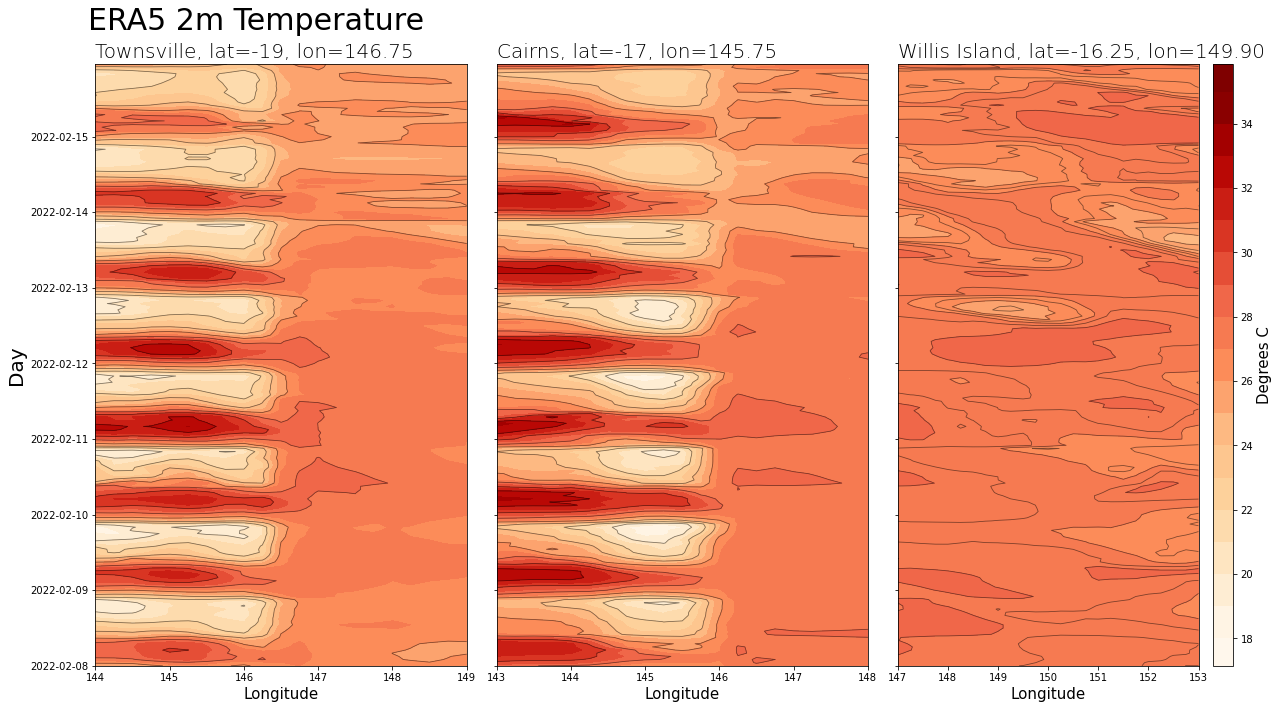

In [172]:
# make plot
# Start figure
fig, ax = plt.subplots(1,3,figsize=(18,10))
fig.patch.set_facecolor('white')

# Set some titles
ax[0].set_title('Townsville, lat=-19, lon=146.75', loc='left', fontsize=20,fontweight=0.9)
ax[1].set_title('Cairns, lat=-17, lon=145.75', loc='left', fontsize=20,fontweight=0.9)
ax[2].set_title('Willis Island, lat=-16.25, lon=149.90', loc='left', fontsize=20,fontweight=0.9)
#fig.figure.suptitle('ERA5 Time Range: {0:%Y-%m-%d %H UTC} to {1:%Y-%m-%d %H UTC}'.format(variable_times[0], variable_times[-1]),
#          fontsize=12)
fig.figure.suptitle("ERA5 2m Temperature",x=0.2,y=0.98,fontsize=30)

# Plot of chosen variable averaged over latitude and slightly smoothed
levels = [18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]
cf = ax[0].contourf(lons, variable_times, variable_data, levels=levels, cmap="OrRd", extend='both')
cf_C = ax[1].contourf(lons_C, variable_times_C, variable_data_C, levels=levels, cmap="OrRd", extend='both')
cf_W = ax[2].contourf(lons_W, variable_times_W, variable_data_W, levels=levels, cmap="OrRd", extend='both')

line_colors = ['black' for l in cf.levels]
cs = ax[0].contour(lons, variable_times, variable_data, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
cs_C = ax[1].contour(lons_C, variable_times_C, variable_data_C, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
cs_W = ax[2].contour(lons_W, variable_times_W, variable_data_W, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')

#plt.clabel(cs,levels,inline=True, fontsize=9, colors=line_colors)
#cbar = plt.colorbar(cf,ax=ax[0],orientation='vertical', pad=0.04, aspect=30, extendrect=True)
#cbar_C = plt.colorbar(cf_C, ax=ax[1],orientation='vertical', pad=0.04, aspect=30, extendrect=True)
cbar_W = plt.colorbar(cf_W, ax=ax[2],orientation='vertical', pad=0.04, aspect=30, extendrect=True)
cbar_W.set_label('Degrees C',fontsize=15)

# Make some ticks and tick labels
xticks = np.arange(144,150,1)
xticks_C = np.arange(143,149,1)
xticks_W = np.arange(147,154,1)
ax[0].set_xticks(xticks)
ax[1].set_xticks(xticks_C)
ax[2].set_xticks(xticks_W)

x_tick_labels = ["144","145","146","147","148","149"]
x_tick_labels_C = ["143","144","145","146","147","148"]
x_tick_labels_W = ["147","148","149","150","151","152","153"]
ax[0].set_xticklabels(x_tick_labels)
ax[1].set_xticklabels(x_tick_labels_C)
ax[2].set_xticklabels(x_tick_labels_W)

ax[1].set(yticklabels=[]) 
ax[2].set(yticklabels=[]) 

ax[0].set_xlabel("Longitude",fontsize=15)
ax[1].set_xlabel("Longitude",fontsize=15)
ax[2].set_xlabel("Longitude",fontsize=15)
ax[0].set_ylabel("Day",fontsize=20)

fig.tight_layout()
#figs = ax[0].get_figure()
#figs.savefig(outdir+"Hovmoller_2022_02_u10")
plt.show()

# Temperature Anomaly Plot

In [9]:
# read in era5 data
variable = '2t'
Year = '2022'
indir = '/g/data/rt52/era5/single-levels/reanalysis/'+variable+'/'+Year+'/' # path to where data is saved
print('indir: ',indir)
file = indir+variable+'_era5_oper_sfc_20220201-20220228.nc' # path to file
print('file: ',file)

indir:  /g/data/rt52/era5/single-levels/reanalysis/2t/2022/
file:  /g/data/rt52/era5/single-levels/reanalysis/2t/2022/2t_era5_oper_sfc_20220201-20220228.nc


In [10]:
era5_ds = xr.open_dataset(file, engine="netcdf4")
era5_ds["t2m"].attrs

{'units': 'K', 'long_name': '2 metre temperature'}

In [17]:
# Prepare data + make plots: https://unidata.github.io/python-gallery/examples/Hovmoller_Diagram.html
# create time slices between 25th and 28th
start_time = '2022-02-08T00:00:00'
end_time = '2022-02-15T23:00:00'
time_slice = slice(start_time, end_time)
lat_slice = -19  #-16 degrees is cairns latitude, -19 degrees is Townsville
lat_slice_C = -17
lat_slice_W = -16.25
lon_slice = slice(144, 149)                  # 143-148 is longitude for zoomed in version of Townsville and Cairns
lon_slice_C = slice(143,148)
lon_slice_W = slice(147,153)

# Get data, selecting time, lat/lon slice
variable_data = (era5_ds["t2m"].sel(latitude=lat_slice,longitude=lon_slice,
                        time=time_slice).groupby("time.day") - era5_ds["t2m"].sel(latitude=lat_slice,longitude=lon_slice,
                        time=time_slice).groupby("time.day").mean())
variable_data_C = (era5_ds["t2m"].sel(latitude=lat_slice_C,longitude=lon_slice_C,
                        time=time_slice).groupby("time.day") - era5_ds["t2m"].sel(latitude=lat_slice_C,longitude=lon_slice_C,
                        time=time_slice).groupby("time.day").mean()) 
variable_data_W = (era5_ds["t2m"].sel(latitude=lat_slice_W,longitude=lon_slice_W,
                        time=time_slice).groupby("time.day") - era5_ds["t2m"].sel(latitude=lat_slice_W,longitude=lon_slice_W,
                        time=time_slice).groupby("time.day").mean())

# Get times and make array of datetime objects
variable_times = variable_data.time.values.astype('datetime64[ms]').astype('O')
variable_times_C = variable_data_C.time.values.astype('datetime64[ms]').astype('O')
variable_times_W = variable_data_W.time.values.astype('datetime64[ms]').astype('O')

# Specify longitude values for chosen domain
lons = variable_data.longitude.values
lons_C = variable_data_C.longitude.values
lons_W = variable_data_W.longitude.values

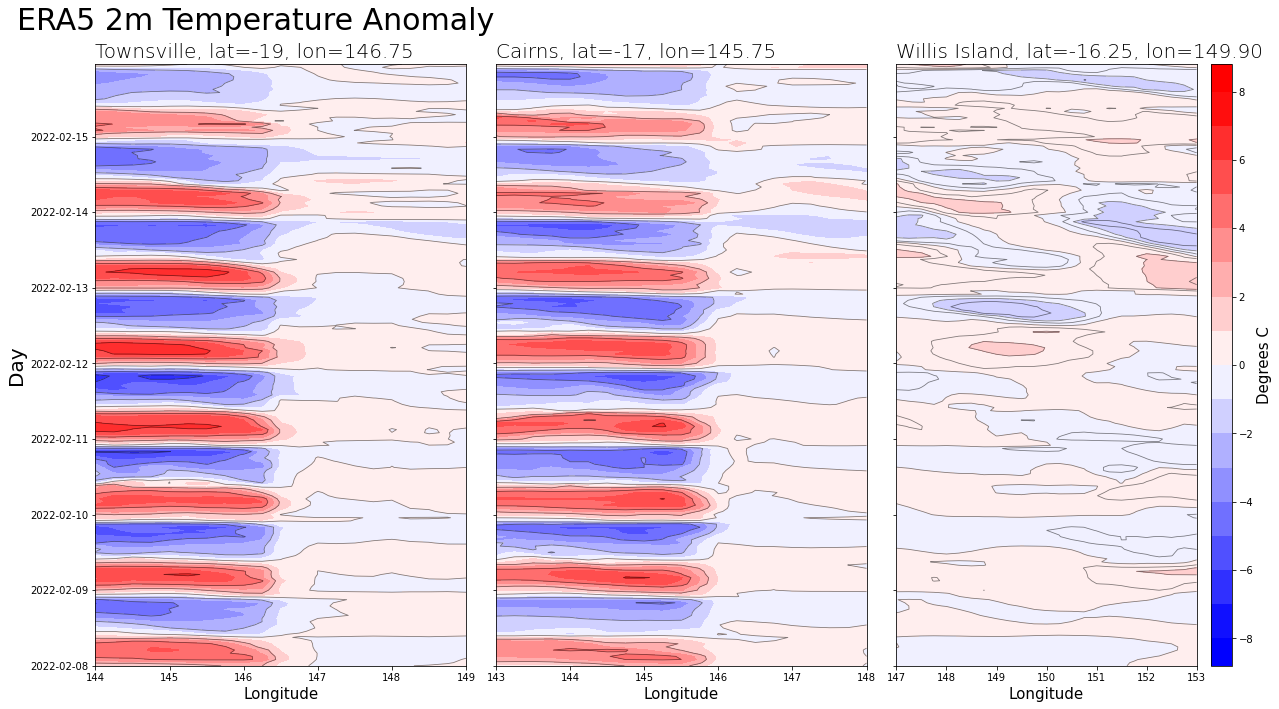

In [21]:
# make plot
fig, ax = plt.subplots(1,3,figsize=(18,10))
fig.patch.set_facecolor('white')

# Set some titles
ax[0].set_title('Townsville, lat=-19, lon=146.75', loc='left', fontsize=20,fontweight=0.9)
ax[1].set_title('Cairns, lat=-17, lon=145.75', loc='left', fontsize=20,fontweight=0.9)
ax[2].set_title('Willis Island, lat=-16.25, lon=149.90', loc='left', fontsize=20,fontweight=0.9)
fig.figure.suptitle("ERA5 2m Temperature Anomaly",x=0.2,y=0.98,fontsize=30)

# Plot of chosen variable averaged over latitude and slightly smoothed
levels = [-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8]
cf = ax[0].contourf(lons, variable_times, variable_data, levels=levels, cmap="bwr", extend='both')
cf_C = ax[1].contourf(lons_C, variable_times_C, variable_data_C, levels=levels, cmap="bwr", extend='both')
cf_W = ax[2].contourf(lons_W, variable_times_W, variable_data_W, levels=levels, cmap="bwr", extend='both')

line_colors = ['black' for l in cf.levels]
cs = ax[0].contour(lons, variable_times, variable_data, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
cs_C = ax[1].contour(lons_C, variable_times_C, variable_data_C, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
cs_W = ax[2].contour(lons_W, variable_times_W, variable_data_W, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')

cbar_W = plt.colorbar(cf_W, ax=ax[2],orientation='vertical', pad=0.04, aspect=30, extendrect=True)
cbar_W.set_label('Degrees C',fontsize=15)

# Make some ticks and tick labels
xticks = np.arange(144,150,1)
xticks_C = np.arange(143,149,1)
xticks_W = np.arange(147,154,1)
ax[0].set_xticks(xticks)
ax[1].set_xticks(xticks_C)
ax[2].set_xticks(xticks_W)

x_tick_labels = ["144","145","146","147","148","149"]
x_tick_labels_C = ["143","144","145","146","147","148"]
x_tick_labels_W = ["147","148","149","150","151","152","153"]
ax[0].set_xticklabels(x_tick_labels)
ax[1].set_xticklabels(x_tick_labels_C)
ax[2].set_xticklabels(x_tick_labels_W)

ax[1].set(yticklabels=[]) 
ax[2].set(yticklabels=[]) 

ax[0].set_xlabel("Longitude",fontsize=15)
ax[1].set_xlabel("Longitude",fontsize=15)
ax[2].set_xlabel("Longitude",fontsize=15)
ax[0].set_ylabel("Day",fontsize=20)

fig.tight_layout()
plt.show()